## Load example data.

Note: this will only work for relatively short time windows, where all data fits in RAM. Processing a whole day worth of data (or more) requires a different approach.

In [1]:
fs = 1/200e-3

# approx. 3 hours of data
N = int(3 * 3600 / fs)

M = 1024
f = 868.504 + arange(M)/1023*0.192

In [2]:
base = "ws_traffic/ws_traffic_20170803"

# timestamps
ts_raw = memmap(base + ".timestamps.bin", dtype=float64, mode='r')
ts = ts_raw[:N]
print("N = ", N)

# rssi measurements
rssi_raw = memmap(base + ".data.bin", dtype=uint8, mode='r')

assert rssi_raw.shape[0] % M == 0
Nraw = rssi_raw.shape[0]//M

print("M = ", M)

rssi = -1 * array(rssi_raw.reshape(Nraw, M)[:N,:], dtype=float64)

N =  2160
M =  1024


Load Python module with channel quality metrics implementations.

In [3]:
if '.' not in sys.path:
    sys.path.append('.')
import cq

## Channel availability

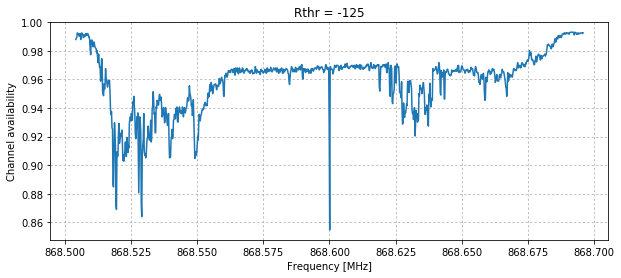

In [4]:
Rthr = -125

method = cq.ChannelAvailabilityMethod(Rthr=Rthr)
ca = method.get_cq(rssi, ts)

figure(figsize=(10,4))
title("Rthr = %.0f" % Rthr)

plot(f, ca)

xlabel("Frequency [MHz]")
ylabel("Channel availability")
grid(ls=':')

## Mean power spectral density

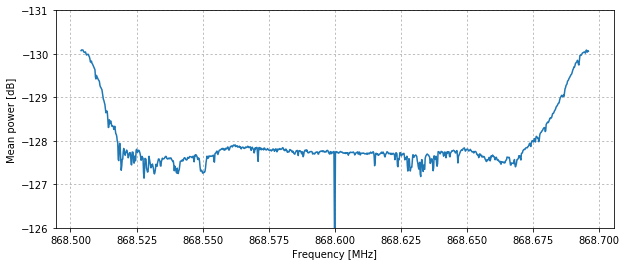

In [5]:
method = cq.MeanPSDMethod()
psd = method.get_cq(rssi, ts)

figure(figsize=(10,4))

plot(f, psd)

axis([None, None, -126, -131])
xlabel("Frequency [MHz]")
ylabel("Mean power [dB]")
grid(ls=':')

## CQ(tau) metric

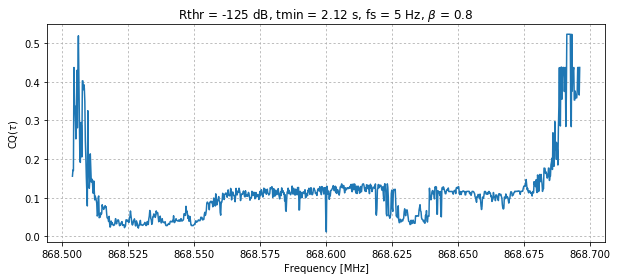

In [6]:
Rthr = -125
tmin = 2.12
beta = 0.8

method = cq.CQTauMethod(Rthr, tmin, fs, beta)
cqtau = method.get_cq(rssi, ts)

figure(figsize=(10,4))
title(r"Rthr = %.0f dB, tmin = %.2f s, fs = %.0f Hz, $\beta$ = %.1f" % (Rthr, tmin, fs, beta))

plot(f, cqtau)

xlabel("Frequency [MHz]")
ylabel(r"CQ($\tau$)")
grid(ls=':')

## Maximum likelyhood estimate - CQ*(tau) metric

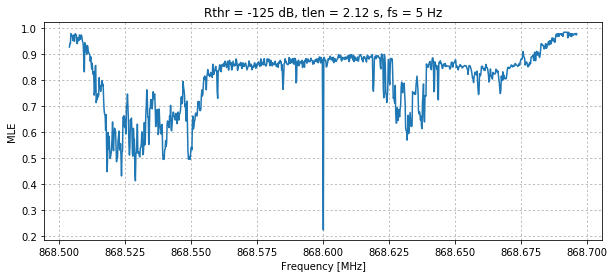

In [7]:
Rthr = -125
tlen = 2.12

method = cq.MLEMethod(Rthr, tmin, fs)
cqtau = method.get_cq(rssi, ts)

figure(figsize=(10,4))
title("Rthr = %.0f dB, tlen = %.2f s, fs = %.0f Hz" % (Rthr, tmin, fs))

plot(f, cqtau)

xlabel("Frequency [MHz]")
ylabel(r"MLE")
grid(ls=':')

## PRR(SINR) metric

Calculate ideal PRR(SINR) for BPSK (we could load the actual measured characteristic here instead)

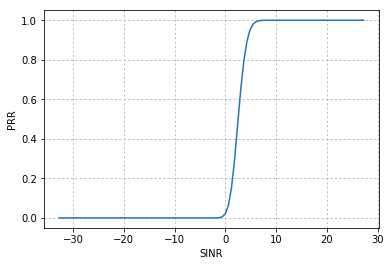

In [8]:
from scipy.special import erfc

# noise measurement bandwidth in hertz
B = 192e3 / M
# number of bits
Nbits = (4 + 14) * 8
# bitrate (bit/s)
fb = 100

EbN0 = linspace(-30, 30, 100)

ber = .5 * erfc(sqrt(10.**(EbN0/10)))

ref_prr = (1 - ber)**Nbits
ref_sinr = EbN0 + 10. * log10(fb / B)

plot(ref_sinr, ref_prr)
ylabel("PRR")
xlabel("SINR")
grid(ls=':')

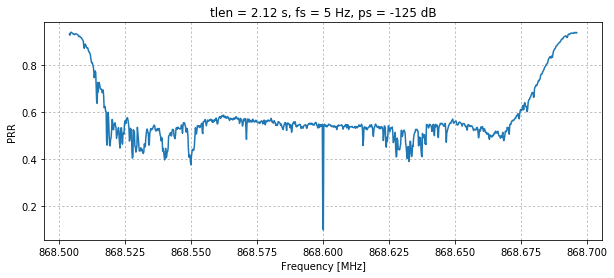

In [9]:
tlen = 2.12
ps = -125

method = cq.SINRMethod(tlen, fs, ps, ref_sinr, ref_prr)
cqtau = method.get_cq(rssi, ts)

figure(figsize=(10,4))
title("tlen = %.2f s, fs = %.0f Hz, ps = %.0f dB" % (tmin, fs, ps))

plot(f, cqtau)

xlabel("Frequency [MHz]")
ylabel(r"PRR")
grid(ls=':')